In [1]:
import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from repeated_values import rows_no_change, summary_change
import tensorflow as tf
from tensorflow import keras
from keras import layers

id_t = 1002

path = '../data/processed/'

tpath = path + 'trafico/'
filestpath = tpath + 'files_per_loc/'

mpath = path + 'meteo/'
filesmpath = mpath + 'files_per_station/'

tmagns = ['intensidad', 'ocupacion', 'vmed']
mmagns = ['temperatura', 'humedad_relativa', 'presion_barometrica', 'radiacion_solar',
          'precipitacion', 'vientox', 'vientoy']

mapping = pd.read_csv(path + 'id_mapping.csv')
ids_m = mapping[mapping.id_t == id_t].iloc[0][[f'id_{magn}' for magn in mmagns]].astype(int)


dft = pd.read_csv(filestpath + f'{id_t:.0f}.csv', parse_dates=['fecha'], index_col='fecha')
#dfm = pd.read_csv(filesmpath + f'estacion-{id_m:.0f}.csv', parse_dates=['fecha'], index_col='fecha')
dfm = {estacion: pd.read_csv(filesmpath + f'estacion-{estacion:.0f}.csv', parse_dates=['fecha'], index_col='fecha') for estacion in ids_m.unique()}

nt = dft[tmagns].apply(rows_no_change)
for m in tmagns:
    dft[m] = np.where(nt[m]>4, np.nan, dft[m])
    

for estacion, dfmi in dfm.items():
    nm = dfmi[mmagns].apply(rows_no_change)
    for m in mmagns:
        if m in ['precipitacion', 'radiacion_solar', 'presion_barometrica']:
            continue
        dfmi[m] = np.where((nm[m]>4) & (dfmi[m]!=0), np.nan, dfmi[m])
        
df = dft
del dft
for m in mmagns:
    df = df.merge(dfm[ids_m[f"id_{m}"]][[m]],
                 left_index=True, right_index=True,
                how='left')
df = df.sort_index()
df[mmagns] = df[mmagns].fillna(method="ffill", limit=4)

cal = pd.read_csv(path+'calendario.csv', sep=';')
cal['fecha'] = pd.to_datetime(cal['Día'], dayfirst=True)
cal['laborable / festivo / domingo festivo'] = cal['laborable / festivo / domingo festivo'].str.lower()
festivos = cal[cal['laborable / festivo / domingo festivo']=='festivo'].fecha.dt.date.unique()

df['dia_semana'] = df.index.day_of_week
df.loc[df.dia_semana < 5, 'tipo_dia'] = 'laborable'
df.loc[df.dia_semana == 5, 'tipo_dia'] = 'sabado'
df.loc[(df.dia_semana == 6 ) | (pd.Series(df.index.date).isin(festivos)), 'tipo_dia'] = 'domingo/festivo'
df = df.merge(df.tipo_dia.str.get_dummies().iloc[:, [1, 2]], left_index=True, right_index=True)
del df['dia_semana'], df['tipo_dia']

timestamp_s = df.index.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

df['dia_sen'] = np.sin(timestamp_s * (2 * np.pi / day))
df['dia_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['ano_sen'] = np.sin(timestamp_s * (2 * np.pi / year))
df['ano_cos'] = np.cos(timestamp_s * (2 * np.pi / year))

df.head()

2022-02-23 08:48:35.512912: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-23 08:48:35.513026: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


,intensidad,ocupacion,vmed,temperatura,humedad_relativa,presion_barometrica,radiacion_solar,precipitacion,vientox,vientoy,laborable,sabado,dia_sen,dia_cos,ano_sen,ano_cos
fecha,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,132.0,0.0,69.0,2.6,98.0,943.0,1.0,0.1,0.018500,1.059839,1,0,-6.012051e-12,1.000000,0.010881,0.999941
2021-01-01 00:15:00,132.0,0.0,71.0,2.6,98.0,943.0,1.0,0.1,0.018500,1.059839,1,0,6.540313e-02,0.997859,0.011060,0.999939
2021-01-01 00:30:00,96.0,1.0,63.0,2.6,98.0,943.0,1.0,0.1,0.018500,1.059839,1,0,1.305262e-01,0.991445,0.011239,0.999937
2021-01-01 00:45:00,636.0,2.0,67.0,2.6,98.0,943.0,1.0,0.1,0.018500,1.059839,1,0,1.950903e-01,0.980785,0.011418,0.999935
2021-01-01 01:00:00,1644.0,6.0,65.0,2.4,97.0,944.0,1.0,0.0,-1.018858,-0.885680,1,0,2.588190e-01,0.965926,0.011597,0.999933


In [2]:
df.describe()

,intensidad,ocupacion,vmed,temperatura,humedad_relativa,presion_barometrica,radiacion_solar,precipitacion,vientox,vientoy,laborable,sabado,dia_sen,dia_cos,ano_sen,ano_cos
count,29022.000000,26325.000000,28719.000000,33610.000000,32834.000000,25702.000000,33610.000000,33610.000000,33610.000000,33610.000000,35032.000000,35032.000000,3.503200e+04,3.503200e+04,35032.000000,35032.000000
mean,1542.937427,7.231605,60.994881,14.849408,59.719102,947.844098,189.750074,0.042993,-0.334797,-0.102074,0.715203,0.142498,-8.522301e-05,2.487612e-05,-0.000132,-0.000786
std,1122.887318,4.881474,12.264337,8.751445,23.042909,5.224713,273.827607,0.351873,1.502772,1.326998,0.451324,0.349565,7.071632e-01,7.070705e-01,0.707350,0.706883
min,0.000000,0.000000,0.000000,-11.900000,7.000000,931.000000,1.000000,0.000000,-6.550121,-5.827361,0.000000,0.000000,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000
25%,468.000000,3.000000,63.000000,8.800000,41.000000,944.000000,1.000000,0.000000,-1.133746,-0.839966,0.000000,0.000000,-7.071068e-01,-7.071068e-01,-0.707586,-0.707597
50%,1605.000000,8.000000,64.000000,14.000000,59.000000,947.000000,6.000000,0.000000,0.011519,0.045018,1.000000,0.000000,4.979055e-16,4.979055e-16,-0.001312,-0.001401
75%,2316.000000,10.000000,66.000000,20.700000,78.000000,951.000000,341.000000,0.000000,0.669082,0.606249,1.000000,0.000000,7.071068e-01,7.071068e-01,0.707342,0.705868
max,5964.000000,64.000000,120.000000,41.400000,100.000000,963.000000,1044.000000,9.600000,4.805862,5.237673,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000


In [3]:
for c in tmagns + mmagns:
    df[f'missing_{c}'] = np.where(df[c].isnull(), 1, 0)
    df[c] = df[c].fillna(df[c].mean())

df.describe()

,intensidad,ocupacion,vmed,temperatura,humedad_relativa,presion_barometrica,radiacion_solar,precipitacion,vientox,vientoy,...,missing_intensidad,missing_ocupacion,missing_vmed,missing_temperatura,missing_humedad_relativa,missing_presion_barometrica,missing_radiacion_solar,missing_precipitacion,missing_vientox,missing_vientoy
count,35032.000000,35032.000000,35032.000000,35032.000000,35032.000000,35032.000000,35032.000000,35032.000000,35032.000000,35032.000000,...,35032.000000,35032.000000,35032.000000,35032.000000,35032.000000,35032.000000,35032.000000,35032.000000,35032.000000,35032.000000
mean,1542.937427,7.231605,60.994881,14.849408,59.719102,947.844098,189.750074,0.042993,-0.334797,-0.102074,...,0.171557,0.248544,0.180207,0.040591,0.062743,0.266328,0.040591,0.040591,0.040591,0.040591
std,1022.035770,4.231561,11.104395,8.571983,22.308292,4.475187,268.212342,0.344657,1.471956,1.299786,...,0.377001,0.432175,0.384365,0.197345,0.242503,0.442044,0.197345,0.197345,0.197345,0.197345
min,0.000000,0.000000,0.000000,-11.900000,7.000000,931.000000,1.000000,0.000000,-6.550121,-5.827361,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,684.000000,5.000000,60.994881,8.900000,43.000000,945.000000,1.000000,0.000000,-1.075786,-0.801098,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1542.937427,7.231605,64.000000,14.500000,59.719102,947.844098,14.000000,0.000000,-0.108464,0.027400,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2184.000000,9.000000,66.000000,20.400000,77.000000,949.000000,324.250000,0.000000,0.647527,0.560252,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,5964.000000,64.000000,120.000000,41.400000,100.000000,963.000000,1044.000000,9.600000,4.805862,5.237673,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
intensidad = df.intensidad.values
intensidad

array([132., 132.,  96., ..., 420., 396., 168.])

In [5]:
raw_data = df.values
raw_data

array([[132.,   0.,  69., ...,   0.,   0.,   0.],
       [132.,   0.,  71., ...,   0.,   0.,   0.],
       [ 96.,   1.,  63., ...,   0.,   0.,   0.],
       ...,
       [420.,   2.,  70., ...,   0.,   0.,   0.],
       [396.,   2.,  68., ...,   0.,   0.,   0.],
       [168.,   1.,  67., ...,   0.,   0.,   0.]])

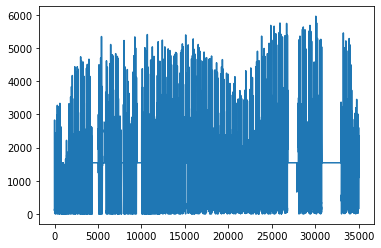

In [6]:
plt.plot(range(len(intensidad)), intensidad)

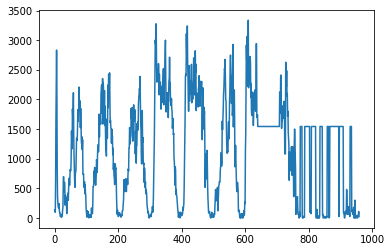

In [7]:
plt.plot(range(10*4*24), intensidad[:10*4*24])

In [8]:
intensidad

array([132., 132.,  96., ..., 420., 396., 168.])

In [9]:
raw_data[:, 0]

array([132., 132.,  96., ..., 420., 396., 168.])

In [10]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 17516
num_val_samples: 8758
num_test_samples: 8758


In [11]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [12]:
raw_data

array([[-1.30905291, -1.89632426,  0.67772297, ..., -0.26111118,
        -0.26111118, -0.26111118],
       [-1.30905291, -1.89632426,  0.82569264, ..., -0.26111118,
        -0.26111118, -0.26111118],
       [-1.3429026 , -1.63272928,  0.23381395, ..., -0.26111118,
        -0.26111118, -0.26111118],
       ...,
       [-1.0382554 , -1.3691343 ,  0.7517078 , ..., -0.26111118,
        -0.26111118, -0.26111118],
       [-1.06082186, -1.3691343 ,  0.60373813, ..., -0.26111118,
        -0.26111118, -0.26111118],
       [-1.27520322, -1.63272928,  0.5297533 , ..., -0.26111118,
        -0.26111118, -0.26111118]])

In [13]:
int_sequence = np.arange(10)
dummy_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)
 
for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

2022-02-23 08:50:08.397519: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-23 08:50:08.397631: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-23 08:50:08.397713: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (elena-Aspire-ES1-521): /proc/driver/nvidia/version does not exist


[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [14]:
from tensorflow import keras

In [15]:
sampling_rate = 4 # 1 observation per hour
sequence_length = 120 # 5 days = 120 hours
delay = sampling_rate * (sequence_length + 24 - 1) # target is 24 hours ahead
batch_size = 256 
  
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=intensidad[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)
  
val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=intensidad[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)
  
test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=intensidad[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [16]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 26)
targets shape: (256,)


In [17]:
mean

array([ 1.52421090e+03,  7.19408332e+00,  5.98397044e+01,  1.25764637e+01,
        6.27927802e+01,  9.47899935e+02,  1.91434036e+02,  4.20567681e-02,
       -3.68506609e-01, -2.46612075e-02,  7.15403060e-01,  1.42498287e-01,
        1.57708364e-03, -1.18963778e-04,  6.36898721e-01, -6.56923887e-03,
        1.44039735e-01,  2.43434574e-01,  1.53231331e-01,  6.38273578e-02,
        8.52934460e-02,  4.88410596e-01,  6.38273578e-02,  6.38273578e-02,
        6.38273578e-02,  6.38273578e-02])

# Evaluar baseline (intensidad en 24 horas es la misma que ahora)

In [121]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 0] * std[0] + mean[0]
        total_abs_err += np.sum(np.abs(preds-targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}") 
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 394.39
Test MAE: 289.05


<AxesSubplot:>

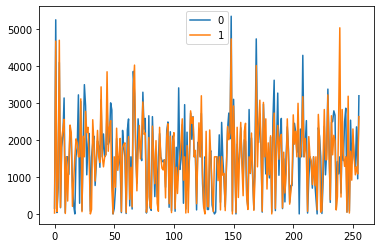

In [120]:
pd.concat([pd.Series(samples[:, -1, 0] * std[0] + mean[0]), pd.Series(targets)], axis=1).plot()

# Evaluar modelo sencillo

In [130]:
raw_data.shape

(35032, 26)

In [185]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation='relu')(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("intensidad.keras", save_best_only=True)
]

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=callbacks
)

model = keras.models.load_model('intensidad.keras')
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/20
67/67 [==============================] - 9s 109ms/step - loss: 3401133.0000 - mae: 1512.9200 - val_loss: 3193953.2500 - val_mae: 1462.6313
Epoch 2/20
67/67 [==============================] - 7s 105ms/step - loss: 3197034.5000 - mae: 1461.7284 - val_loss: 3060660.0000 - val_mae: 1424.8175
Epoch 3/20
67/67 [==============================] - 8s 113ms/step - loss: 2934523.7500 - mae: 1393.5431 - val_loss: 2886545.0000 - val_mae: 1373.9080
Epoch 4/20
67/67 [==============================] - 10s 145ms/step - loss: 2623675.5000 - mae: 1307.1576 - val_loss: 2677304.0000 - val_mae: 1309.3771
Epoch 5/20
67/67 [==============================] - 8s 113ms/step - loss: 2278007.5000 - mae: 1201.1501 - val_loss: 2437483.5000 - val_mae: 1230.8829
Epoch 6/20
67/67 [==============================] - 9s 135ms/step - loss: 1924795.0000 - mae: 1078.0867 - val_loss: 2183531.7500 - val_mae: 1141.6199
Epoch 7/20
67/67 [==============================] - 12s 170ms/step - loss: 1590803.0000 - mae: 944.

In [186]:
for samples, targets in train_dataset:
    print(samples.shape)
    print(targets.shape)
    break

(256, 120, 26)
(256,)


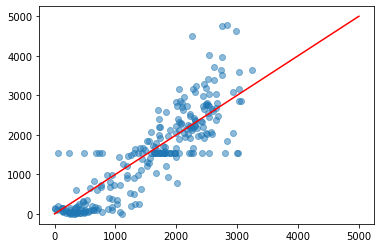

In [187]:
for samples, targets in train_dataset:
    break
n = 1000
preds = model.predict(samples[:n]).ravel()
labels = targets[:n].numpy()
plt.scatter(preds, labels, alpha=0.5)
plt.plot([0, 5000],[0,5000], color='red')
plt.show()

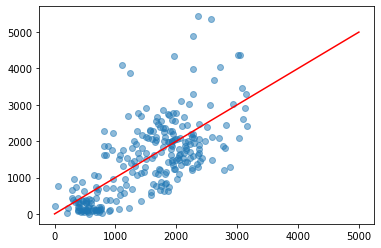

In [189]:
for samples, targets in val_dataset:
    break
n = 1000
preds = model.predict(samples[:n]).ravel()
labels = targets[:n].numpy()
plt.scatter(preds, labels, alpha=0.5)
plt.plot([0, 5000],[0,5000], color='red')
plt.show()

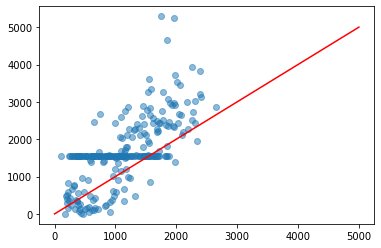

In [188]:
for samples, targets in test_dataset:
    break
n = 1000
preds = model.predict(samples[:n]).ravel()
labels = targets[:n].numpy()
plt.scatter(preds, labels, alpha=0.5)
plt.plot([0, 5000],[0,5000], color='red')
plt.show()

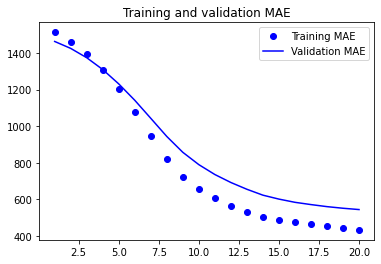

In [190]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [178]:
loss

[1499.6925048828125,
 1422.742919921875,
 1324.2838134765625,
 1202.634033203125,
 1059.976318359375,
 911.201904296875,
 790.2513427734375,
 705.959716796875,
 641.0459594726562,
 588.3272705078125]

# Modelo convolucional unidimensional

In [192]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("intensidad_conv.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
  
model = keras.models.load_model("intensidad_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
67/67 [==============================] - 19s 256ms/step - loss: 3110182.5000 - mae: 1434.4008 - val_loss: 1719248.8750 - val_mae: 1032.1051
Epoch 2/10
67/67 [==============================] - 15s 213ms/step - loss: 1459814.3750 - mae: 979.5217 - val_loss: 1136432.1250 - val_mae: 864.3058
Epoch 3/10
67/67 [==============================] - 16s 236ms/step - loss: 1077939.0000 - mae: 820.2181 - val_loss: 1177455.3750 - val_mae: 880.3894
Epoch 4/10
67/67 [==============================] - 16s 234ms/step - loss: 1068586.8750 - mae: 816.8004 - val_loss: 1184124.0000 - val_mae: 881.7857
Epoch 5/10
67/67 [==============================] - 17s 242ms/step - loss: 1064002.0000 - mae: 814.7643 - val_loss: 1227552.7500 - val_mae: 894.7471
Epoch 6/10
67/67 [==============================] - 18s 268ms/step - loss: 1062015.7500 - mae: 813.6684 - val_loss: 1164640.1250 - val_mae: 871.6416
Epoch 7/10
67/67 [==============================] - 21s 313ms/step - loss: 1059484.5000 - mae: 812.2309 

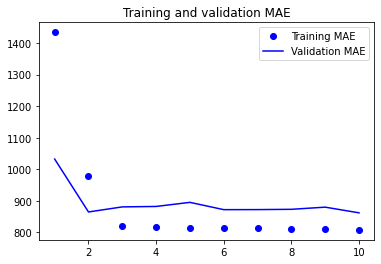

In [193]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

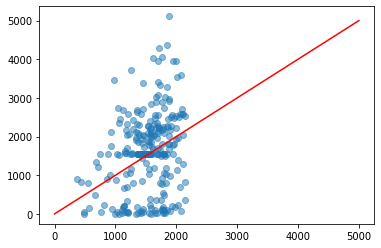

In [194]:
for samples, targets in train_dataset:
    break
n = 1000
preds = model.predict(samples[:n]).ravel()
labels = targets[:n].numpy()
plt.scatter(preds, labels, alpha=0.5)
plt.plot([0, 5000],[0,5000], color='red')
plt.show()

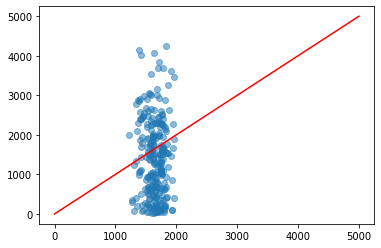

In [195]:
for samples, targets in val_dataset:
    break
n = 1000
preds = model.predict(samples[:n]).ravel()
labels = targets[:n].numpy()
plt.scatter(preds, labels, alpha=0.5)
plt.plot([0, 5000],[0,5000], color='red')
plt.show()

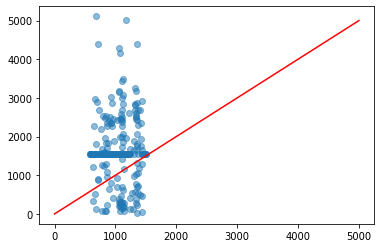

In [196]:
for samples, targets in test_dataset:
    break
n = 1000
preds = model.predict(samples[:n]).ravel()
labels = targets[:n].numpy()
plt.scatter(preds, labels, alpha=0.5)
plt.plot([0, 5000],[0,5000], color='red')
plt.show()

# Modelo LSTM sin normalizar

In [18]:
lstm_raw_data = raw_data#[:, :1]
#lstm_intensidad = raw_data[:, 0]
lstm_intensidad = intensidad

sampling_rate = 4 # 1 observation per hour
sequence_length = 120 # 5 days = 120 hours
delay = sampling_rate * (sequence_length + 24 - 1) # target is 24 hours ahead
batch_size = 256 
  
lstm_train_dataset = keras.utils.timeseries_dataset_from_array(
    lstm_raw_data[:-delay],
    targets=lstm_intensidad[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)
  
lstm_val_dataset = keras.utils.timeseries_dataset_from_array(
    lstm_raw_data[:-delay],
    targets=lstm_intensidad[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)
  
lstm_test_dataset = keras.utils.timeseries_dataset_from_array(
    lstm_raw_data[:-delay],
    targets=lstm_intensidad[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [19]:
for samples, targets in lstm_train_dataset:
    break

In [20]:
samples[0]

<tf.Tensor: shape=(120, 26), dtype=float64, numpy=
array([[ 2.31286372,  2.05760047,  0.08546559, ..., -0.26111118,
        -0.26111118, -0.26111118],
       [ 2.00821652,  1.79400549,  0.08546559, ..., -0.26111118,
        -0.26111118, -0.26111118],
       [ 0.97862184,  1.00322054,  0.23381395, ..., -0.26111118,
        -0.26111118, -0.26111118],
       ...,
       [-1.09467155, -1.63272928,  0.60373813, ..., -0.26111118,
        -0.26111118, -0.26111118],
       [ 0.58652962,  0.21243559,  0.38178363, ..., -0.26111118,
        -0.26111118, -0.26111118],
       [ 2.94472456,  2.58479043,  0.15982912, ..., -0.26111118,
        -0.26111118, -0.26111118]])>

In [21]:
targets[0]

<tf.Tensor: shape=(), dtype=float64, numpy=5016.0>

In [25]:
inputs = keras.Input(shape=(sequence_length, lstm_raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
  
callbacks = [
    keras.callbacks.ModelCheckpoint("intensidad_lstm_sin_normalizar.keras",
                                    save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss',
                                  patience=3,
                                  mode='min')
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(lstm_train_dataset,
                    epochs=100,
                    validation_data=lstm_val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("intensidad_lstm_sin_normalizar.keras") 
print(f"Test MAE: {model.evaluate(lstm_test_dataset)[1]:.2f}")

Epoch 1/100
67/67 [==============================] - 25s 284ms/step - loss: 3488490.5000 - mae: 1533.7943 - val_loss: 3277480.5000 - val_mae: 1484.2017
Epoch 2/100
67/67 [==============================] - 20s 299ms/step - loss: 3478606.7500 - mae: 1530.6974 - val_loss: 3269420.7500 - val_mae: 1481.5065
Epoch 3/100
67/67 [==============================] - 18s 261ms/step - loss: 3473210.5000 - mae: 1528.9498 - val_loss: 3264589.0000 - val_mae: 1479.8086
Epoch 4/100
67/67 [==============================] - 15s 211ms/step - loss: 3468775.0000 - mae: 1527.4973 - val_loss: 3260632.2500 - val_mae: 1478.4252
Epoch 5/100
67/67 [==============================] - 14s 210ms/step - loss: 3464933.5000 - mae: 1526.2452 - val_loss: 3257076.2500 - val_mae: 1477.2036
Epoch 6/100
67/67 [==============================] - 18s 257ms/step - loss: 3461344.7500 - mae: 1525.0957 - val_loss: 3253640.0000 - val_mae: 1476.0364
Epoch 7/100
67/67 [==============================] - 15s 224ms/step - loss: 3457835.2500

OSError: No file or directory found at intensidad_lstm_sin_normalizar.keras

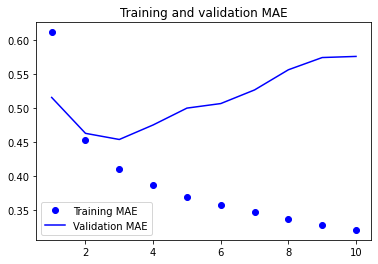

In [410]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [424]:
0.45*std[0] +mean[0]

2002.797289216189

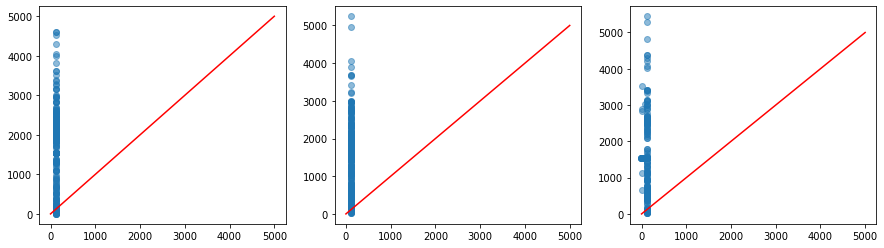

In [27]:
n = 1000
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

for samples, targets in train_dataset:
    break
preds = model.predict(samples[:n]).ravel()#*std[0] + mean[0]
labels = targets[:n].numpy()
ax[0].scatter(preds, labels, alpha=0.5)
ax[0].plot([0, 5000],[0,5000], color='red')

for samples, targets in val_dataset:
    break
preds = model.predict(samples[:n]).ravel()#*std[0] + mean[0]
labels = targets[:n].numpy()
ax[1].scatter(preds, labels, alpha=0.5)
ax[1].plot([0, 5000],[0,5000], color='red')

for samples, targets in test_dataset:
    break
preds = model.predict(samples[:n]).ravel()#*std[0] + mean[0]
labels = targets[:n].numpy()
ax[2].scatter(preds, labels, alpha=0.5)
ax[2].plot([0, 5000],[0,5000], color='red')

plt.show()

In [30]:
preds.shape

(256,)

# Modelo LSTM

In [33]:
lstm_raw_data = raw_data#[:, :1]
lstm_intensidad = raw_data[:, 0]
#lstm_intensidad = intensidad

sampling_rate = 4 # 1 observation per hour
sequence_length = 120 # 5 days = 120 hours
delay = sampling_rate * (sequence_length + 24 - 1) # target is 24 hours ahead
batch_size = 256 
  
lstm_train_dataset = keras.utils.timeseries_dataset_from_array(
    lstm_raw_data[:-delay],
    targets=lstm_intensidad[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)
  
lstm_val_dataset = keras.utils.timeseries_dataset_from_array(
    lstm_raw_data[:-delay],
    targets=lstm_intensidad[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)
  
lstm_test_dataset = keras.utils.timeseries_dataset_from_array(
    lstm_raw_data[:-delay],
    targets=lstm_intensidad[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [37]:
for samples, targets in lstm_train_dataset:
    break

In [38]:
samples[0]

<tf.Tensor: shape=(120, 26), dtype=float64, numpy=
array([[-1.33161937,  0.00989051, -0.13611023, ..., -0.26111118,
        -0.26111118, -0.26111118],
       [-1.28648645,  0.00989051,  0.30779879, ..., -0.26111118,
        -0.26111118, -0.26111118],
       [-1.06082186,  0.00989051,  0.30779879, ..., -0.26111118,
        -0.26111118, -0.26111118],
       ...,
       [-0.94798957, -1.3691343 , -0.35806473, ..., -0.26111118,
        -0.26111118, -0.26111118],
       [-1.4218852 , -1.89632426, -3.61339751, ..., -0.26111118,
        -0.26111118, -0.26111118],
       [-1.27520322, -1.63272928, -1.09791309, ..., -0.26111118,
        -0.26111118, -0.26111118]])>

In [39]:
targets[0]

<tf.Tensor: shape=(), dtype=float64, numpy=-1.3767522858935997>

In [407]:
inputs = keras.Input(shape=(sequence_length, lstm_raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
  
callbacks = [
    keras.callbacks.ModelCheckpoint("lstm_dropout.keras",
                                    save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss',
                                  patience=3,
                                  mode='min')
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(lstm_train_dataset,
                    epochs=50,
                    validation_data=lstm_val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("intensidad_lstm.keras") 
print(f"Test MAE: {model.evaluate(lstm_test_dataset)[1]:.2f}")

Epoch 1/50
67/67 [==============================] - 25s 288ms/step - loss: 0.7521 - mae: 0.6599 - val_loss: 0.8373 - val_mae: 0.7297
Epoch 2/50
67/67 [==============================] - 20s 288ms/step - loss: 0.3895 - mae: 0.4439 - val_loss: 0.6030 - val_mae: 0.6079
Epoch 3/50
67/67 [==============================] - 18s 261ms/step - loss: 0.3220 - mae: 0.4010 - val_loss: 0.5328 - val_mae: 0.5640
Epoch 4/50
67/67 [==============================] - 21s 308ms/step - loss: 0.2896 - mae: 0.3771 - val_loss: 0.4905 - val_mae: 0.5398
Epoch 5/50
67/67 [==============================] - 20s 286ms/step - loss: 0.2676 - mae: 0.3601 - val_loss: 0.4999 - val_mae: 0.5542
Epoch 6/50
67/67 [==============================] - 23s 343ms/step - loss: 0.2514 - mae: 0.3477 - val_loss: 0.4812 - val_mae: 0.5423
Epoch 7/50
67/67 [==============================] - 21s 313ms/step - loss: 0.2383 - mae: 0.3381 - val_loss: 0.4869 - val_mae: 0.5524
Epoch 8/50
67/67 [==============================] - 18s 263ms/step - 

KeyboardInterrupt: 

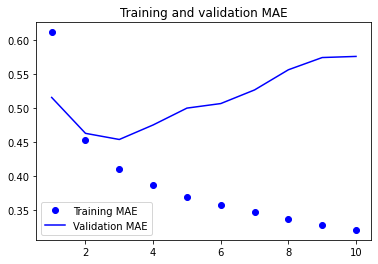

In [410]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [424]:
0.45*std[0] +mean[0]

2002.797289216189

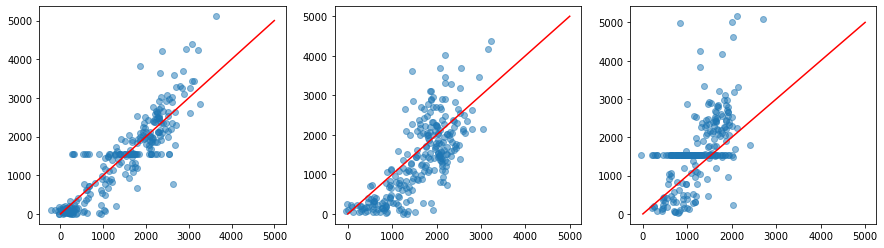

In [423]:
n = 1000
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

for samples, targets in train_dataset:
    break
preds = model.predict(samples[:n]).ravel()*std[0] + mean[0]
labels = targets[:n].numpy()
ax[0].scatter(preds, labels, alpha=0.5)
ax[0].plot([0, 5000],[0,5000], color='red')

for samples, targets in val_dataset:
    break
preds = model.predict(samples[:n]).ravel()*std[0] + mean[0]
labels = targets[:n].numpy()
ax[1].scatter(preds, labels, alpha=0.5)
ax[1].plot([0, 5000],[0,5000], color='red')

for samples, targets in test_dataset:
    break
preds = model.predict(samples[:n]).ravel()*std[0] + mean[0]
labels = targets[:n].numpy()
ax[2].scatter(preds, labels, alpha=0.5)
ax[2].plot([0, 5000],[0,5000], color='red')

plt.show()

# Modelo LSTM más profundo con dropout

In [31]:
import IPython

In [40]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.75)(inputs)
x = layers.Dropout(0.75)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)


callbacks = [
    keras.callbacks.ModelCheckpoint("lstm_dropout.keras",
                                    save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss',
                                  patience=3,
                                  mode='min')
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(lstm_train_dataset,
                    epochs=100,
                    validation_data=lstm_val_dataset,
                    callbacks=callbacks)
IPython.display.clear_output()
model = keras.models.load_model("lstm_dropout.keras") 
print(f"Test MAE: {model.evaluate(lstm_test_dataset)[1]:.2f}")

31/31 [==============================] - 6s 137ms/step - loss: 0.4691 - mae: 0.5397
Test MAE: 0.54


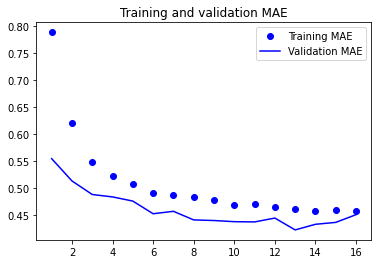

In [41]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

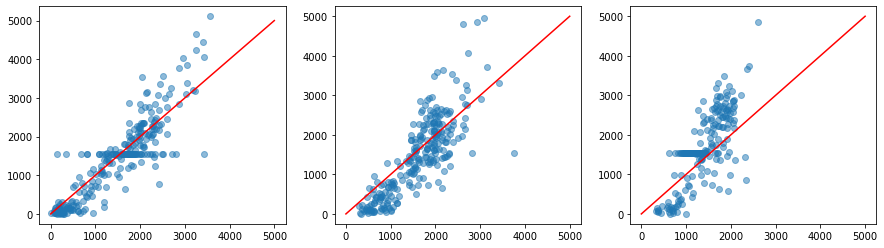

In [432]:
n = 1000
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

for samples, targets in train_dataset:
    break
preds = model.predict(samples[:n]).ravel()*std[0] + mean[0]
labels = targets[:n].numpy()
ax[0].scatter(preds, labels, alpha=0.5)
ax[0].plot([0, 5000],[0,5000], color='red')

for samples, targets in val_dataset:
    break
preds = model.predict(samples[:n]).ravel()*std[0] + mean[0]
labels = targets[:n].numpy()
ax[1].scatter(preds, labels, alpha=0.5)
ax[1].plot([0, 5000],[0,5000], color='red')

for samples, targets in test_dataset:
    break
preds = model.predict(samples[:n]).ravel()*std[0] + mean[0]
labels = targets[:n].numpy()
ax[2].scatter(preds, labels, alpha=0.5)
ax[2].plot([0, 5000],[0,5000], color='red')

plt.show()